In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [86]:
df = pd.read_csv("card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [87]:
# 1. 基础信息探索
print("数据形状：", df.shape)
print("\n缺失值统计：")
print(df.isnull().sum())
print("\n重复值统计：")
print(df.duplicated().sum())
print("\n数据基本统计：")
print(df.describe())

数据形状： (1000000, 8)

缺失值统计：
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

重复值统计：
0

数据基本统计：
       distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985                        3.355748   
max          10632.723672                    11851.104565   

       ratio_to_median_purchase_price  repeat_retailer       used_chip  \
count                  100000

In [88]:
# 2. 标签分布可视化
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

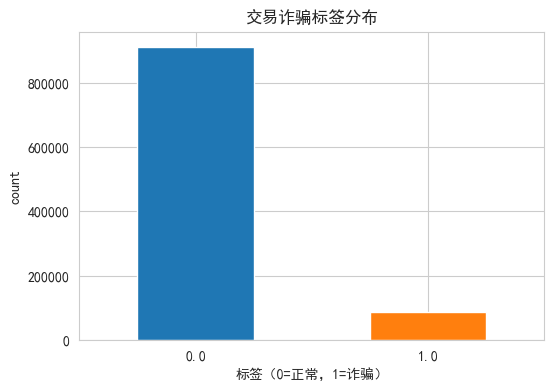

In [89]:
plt.figure(figsize=(6,4))
df['fraud'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('交易诈骗标签分布')
plt.xlabel('标签（0=正常，1=诈骗）')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.savefig("交易诈骗标签分布.png", dpi=300,bbox_inches="tight")
plt.show() # 标签分布不平衡

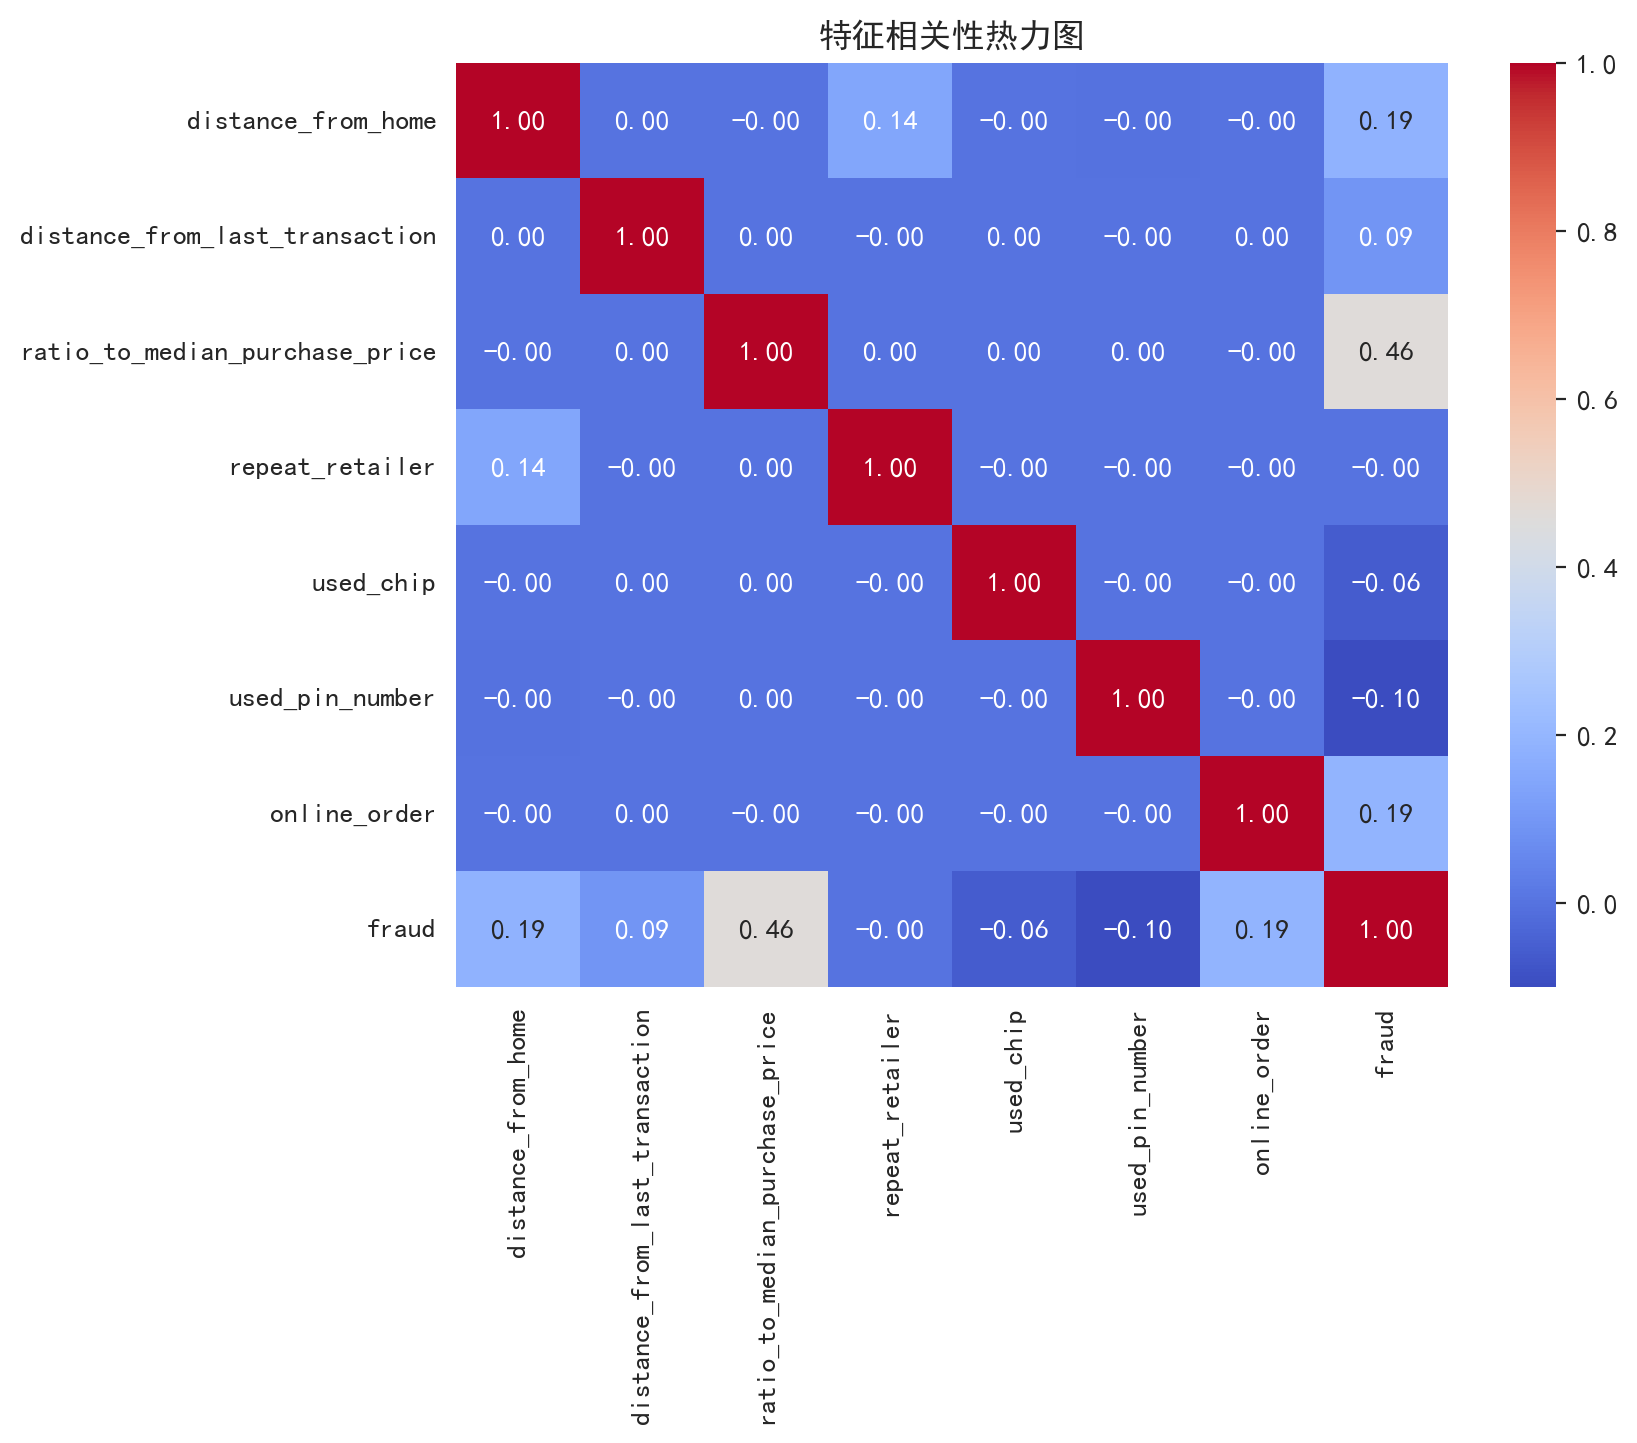

In [90]:
# 3. 特征相关性热力图
plt.figure(figsize=(8,6), dpi=200)
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('特征相关性热力图')
plt.savefig("特征相关性热力图.png", dpi=300,bbox_inches="tight")
plt.show()

In [91]:
# 1. 连续特征分箱（提升模型对非线性关系的捕捉）
# distance_from_home分箱
df['distance_home_bin'] = pd.cut(
    df['distance_from_home'],
    bins=3,
    labels=['近', '中', '远']
)

In [92]:
# ratio_to_median_purchase_price分箱（区分价格异常）
df['price_ratio_bin'] = pd.cut(
    df['ratio_to_median_purchase_price'],
    bins=[-np.inf, 0.5, 1.5, np.inf],
    labels=['低价', '正常价', '高价']
)

In [93]:

# 2. 独热编码分箱特征（转为数值型,使模型正确理解类别关系）
df = pd.get_dummies(df, columns=['distance_home_bin', 'price_ratio_bin'], drop_first=True)

In [94]:

# 3. 拆分特征与标签
X = df.drop('fraud', axis=1)
y = df['fraud']
print("\n特征工程后特征数：", X.shape[1])
df.head()


特征工程后特征数： 11


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,distance_home_bin_中,distance_home_bin_远,price_ratio_bin_正常价,price_ratio_bin_高价
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0,False,False,False,True
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0,False,False,True,False
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0,False,False,False,False
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0,False,False,False,False
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0,False,False,False,True


In [95]:
# 4.过采样少数类（诈骗样本）
from imblearn.over_sampling import SMOTE
resampler = SMOTE(random_state=42)
X_resampled, y_resampled = resampler.fit_resample(X, y)

print("重采样后样本个数：")
print(X_resampled.shape[0])

print("重采样后标签分布：")
print(pd.Series(y_resampled).value_counts(normalize=True).round(3)*100)

重采样后样本个数：
1825194
重采样后标签分布：
fraud
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64


In [96]:
# 5.划分数据集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=66, stratify=y_resampled
)

In [ ]:
# 6.逻辑回归分类
from sklearn.linear_model import LogisticRegression as LR
model_LR = LR(penalty = "l2")
model_LR.fit(X_train, y_train)

In [98]:
model_LR.score(X_train, y_train)

0.941976707952238

In [99]:
# 五折交叉验证
from sklearn.model_selection import cross_val_score as CVS
CVS(model_LR, X_train, y_train, cv=5).mean()

np.float64(0.9409124373782236)

In [100]:
# 6.XGBoost调参
from xgboost import XGBClassifier as XGBC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.08, 0.1, 0.12],
    'reg_alpha': [0.05, 0.1]  # 少量正则化防止过拟合
}

# 网格搜索调优
xgb = XGBC(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

print("最优参数：", grid_search.best_params_)
best_model = grid_search.best_estimator_

最优参数： {'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 120, 'reg_alpha': 0.05}


In [101]:
best_model.score(X_test, y_test)

0.9989946279712578

In [102]:
# 五折交叉验证
CVS(best_model, X_train, y_train, cv=5).mean()

np.float64(0.9988884741688382)

准确率：0.999
AUC：1.000

分类报告：
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182520
         1.0       1.00      1.00      1.00    182519

    accuracy                           1.00    365039
   macro avg       1.00      1.00      1.00    365039
weighted avg       1.00      1.00      1.00    365039



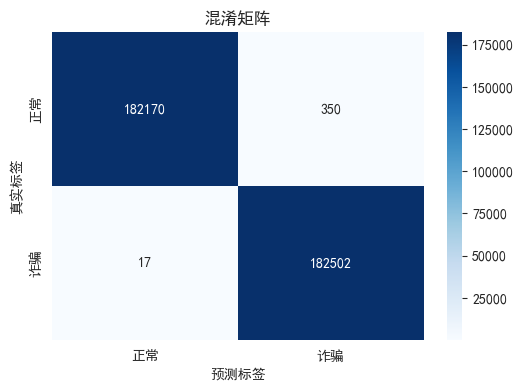

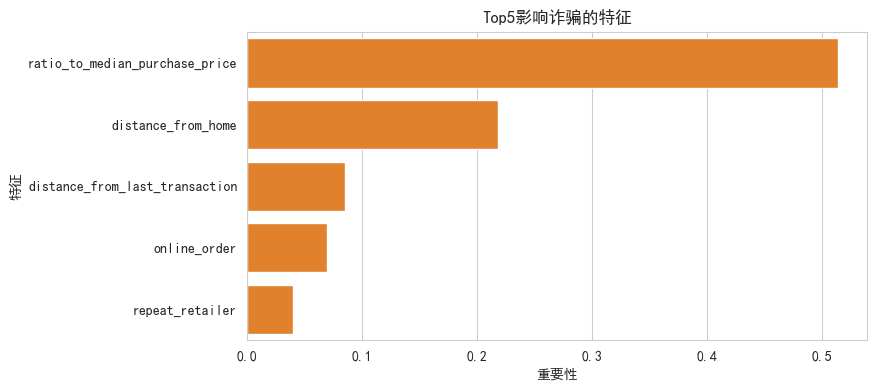

In [103]:
# 7.模型评估
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix

# 预测
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# 核心指标
print(f"准确率：{accuracy_score(y_test, y_pred):.3f}")
print(f"AUC：{roc_auc_score(y_test, y_pred_prob):.3f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred))

# 混淆矩阵（诈骗检测重点看漏判）
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['正常', '诈骗'], yticklabels=['正常', '诈骗'])
plt.title('混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.savefig("混淆矩阵.png", dpi=300,bbox_inches="tight")
plt.show()

# 特征重要性
feat_importance = pd.DataFrame({
    '特征': X.columns,
    '重要性': best_model.feature_importances_
}).sort_values('重要性', ascending=False).head(5)

plt.figure(figsize=(8,4))
sns.barplot(x='重要性', y='特征', data=feat_importance, color='#ff7f0e')
plt.title('Top5影响诈骗的特征')
plt.savefig("Top5影响诈骗的特征.png", dpi=300,bbox_inches="tight")
plt.show()